# Отображение

In [7]:
import os
import cv2
import matplotlib.pyplot as plt

# Функция для чтения разметки из текстового файла
def load_annotations(txt_file):
    annotations = []
    with open(txt_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            rel_x = float(parts[1])
            rel_y = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
            annotations.append((class_id, rel_x, rel_y, width, height))
    return annotations

# Отображение изображений с аннотациями
def draw_boxes(file_name, content):
    img = content['image']
    annotations = content['annotations']
    
    img_height, img_width = img.shape[:2]
    
    for annotation in annotations:
        class_id, rel_x, rel_y, width, height = annotation
        # Преобразование относительных координат в абсолютные
        x_center = int(rel_x * img_width)
        y_center = int(rel_y * img_height)
        width = int(width * img_width)
        height = int(height * img_height)
        
        top_left_x = int(x_center - width / 2)
        top_left_y = int(y_center - height / 2)
        bottom_right_x = int(x_center + width / 2)
        bottom_right_y = int(y_center + height / 2)
        
        # Рисование прямоугольника и подпись
        cv2.rectangle(img, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (0, 0, 0), 5)
        cv2.putText(img, str(class_id), (top_left_x, top_left_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 0), 6)
    
    # Отображение изображения с аннотациями
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(file_name)
    plt.axis('off')
    plt.show()


In [16]:
# Путь к папке с датасетом
dataset_path = '../dataset'

# Словарь для хранения данных
data = {}

dist = [[0, 0, 0, 0, 0] for i in range(13)]

cur_file = 'test.jpg'
cur_file_2 = 'test_rotated.jpg'

# Проход по папке и загрузка данных
for file_name in os.listdir(dataset_path):
    if cur_file == file_name or file_name == cur_file_2:
        if file_name.endswith('.jpg'):
            img_path = os.path.join(dataset_path, file_name)
            txt_path = os.path.join(dataset_path, file_name.split('.')[0] + '.txt')
            # print(txt_path)
            if os.path.exists(txt_path):
                # Загрузка изображения
                img = cv2.imread(img_path)
                # Загрузка аннотаций
                annotations = load_annotations(txt_path)
                # Сохранение в словарь
                data[file_name] = {'image': img, 'annotations': annotations}
                # for i in annotations:
                #     dist[int(file_name.split(' ')[0])][i[0]] += 1
            # break

In [13]:
for id, class_dist in enumerate(dist):
    if class_dist != [0, 0, 0, 0, 0]:
        print(id, class_dist)

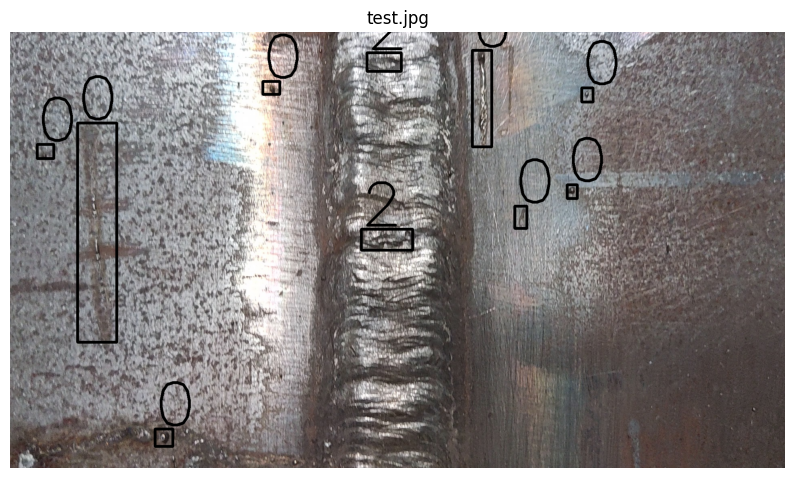

In [17]:
draw_boxes(cur_file, data[cur_file])

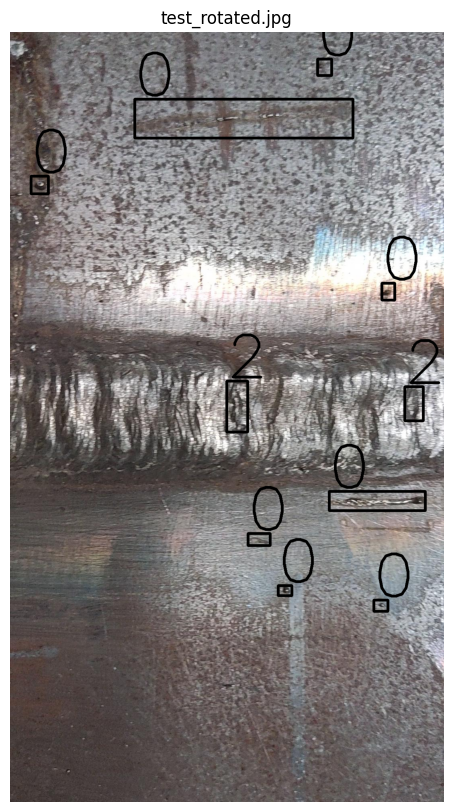

In [18]:
draw_boxes(cur_file_2, data[cur_file_2])

# Разделение на трейн/тест

In [44]:
files = []
for file_name in os.listdir(dataset_path):
    if file_name.endswith('.jpg'):
        img_path = file_name
        txt_path = file_name.split('.')[0] + '.txt'
        files.append((img_path, txt_path))

In [64]:
def mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [69]:
from random import shuffle
import shutil

test_percent = 0.2

shuffle(files)

splited_dataset_path = './splited_dataset'

mkdir(splited_dataset_path)

train_path = f'{splited_dataset_path}/train'
test_path = f'{splited_dataset_path}/test'

mkdir(train_path)
mkdir(test_path)

train_img_path = os.path.join(train_path, 'imgs')
train_lables_path = os.path.join(train_path, 'lables')
test_img_path = os.path.join(test_path, 'imgs')
test_lables_path = os.path.join(test_path, 'lables')

mkdir(train_img_path)
mkdir(train_lables_path)
mkdir(test_img_path)
mkdir(test_lables_path)

test_files = files[:int(len(files)*test_percent)]
train_files = files[int(len(files)*test_percent):]

In [70]:
for img, txt in test_files:
    src_img_path = os.path.join(dataset_path, img)
    src_text_path = os.path.join(dataset_path, txt)

    dst_img_path = os.path.join(test_img_path, img)
    dst_txt_path = os.path.join(test_lables_path, txt)

    shutil.copyfile(src_img_path, dst_img_path)
    shutil.copyfile(src_text_path, dst_txt_path)

for img, txt in train_files:
    src_img_path = os.path.join(dataset_path, img)
    src_text_path = os.path.join(dataset_path, txt)

    dst_img_path = os.path.join(train_img_path, img)
    dst_txt_path = os.path.join(train_lables_path, txt)
    
    shutil.copyfile(src_img_path, dst_img_path)
    shutil.copyfile(src_text_path, dst_txt_path)

In [72]:
print(f"train_count: {len(os.listdir(train_img_path))}\ntest_count: {len(os.listdir(test_img_path))}")

train_count: 930
test_count: 232


# Формирование ответа

In [4]:
# ответ в формате filename;class_id;rel_x;rel_y;width;height

submision_dict = {
    'filename' : [],
    'class_id' : [],
    'rel_x' : [],
    'rel_y' : [],
    'width' : [],
    'height' : []
}

for file_name in os.listdir(dataset_path):
    if file_name.endswith('.jpg'):
        # тут типо считываем изображение и получпаем .txt файл 
        raw_txt_path = os.path.join(dataset_path, file_name.split('.')[0] + '.txt')
        raw_result = load_annotations(raw_txt_path)
        # в raw_result должно быть че-то типо [(class_id, rel_x, rel_y, width, height), ...]
        for class_id, rel_x, rel_y, width, height in raw_result:
            submision_dict['filename'].append(file_name)
            submision_dict['class_id'].append(class_id)
            submision_dict['rel_x'].append(rel_x)
            submision_dict['rel_y'].append(rel_y)
            submision_dict['width'].append(width)
            submision_dict['height'].append(height)

In [5]:
import pandas as pd

pd.DataFrame(submision_dict).to_csv("groupnd_truth.csv", index=False, sep=';')